# APS360 Final Project: Covid Mask Detector

### Names: Edwin Zhang, Lance Canlas, Stefano Katsoras, Marie Joy Cuevas

##### Description/Info/whaterver: 
placeholder

## Global Imports

In [1]:
#Imports
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import os
import random


In [2]:
#Seed constant
SEED_CONST = 2020
#Set seeds to ensure repeatable training
def seed_torch(seed=SEED_CONST):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print("Set all seeds to {}".format(seed))

#initializes worker function for dataloaders
def _init_fn(worker_id):
    np.random.seed(SEED_CONST + worker_id)


## Loading Our Data

Split the data set into 60% train, 20% valdation, 20% test

In [20]:
#Master dataset
master = torchvision.datasets.ImageFolder('data_color_shifted', transform = transforms.ToTensor())

#split indexes
train_size = int(0.6 * len(master))
val_size = int(0.2 *len(master))
test_size = len(master) - val_size - train_size

train_set, val_set, test_set = torch.utils.data.random_split(master, [train_size, val_size, test_size])
print ("Length of training set: {}".format(len(train_set)))
print ("Length of val set: {}".format(len(val_set)))
print ("Length of test set: {}".format(len(test_set)))

Length of training set: 2349
Length of val set: 783
Length of test set: 784


In [4]:
def display_data (data_loader):
    '''
    Displays a few images to see if our data loaded properly
    
    data_loader: torch data_loader
    data_type: a string to show which data is displayed
    '''

    classes = ['Mask', 'No Mask']

    data = iter(data_loader)
    image, label = data.next()
    npImages = image.numpy() 
    
    # plot the images with labels
    fig = plt.figure(figsize=(25, 4))
    for i in np.arange(20):
        ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(npImages[i], (1, 2, 0)))
        ax.set_title(classes[label[i]])

#### Check Our Training Data

<ipython-input-4-859ed0fa2aba>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


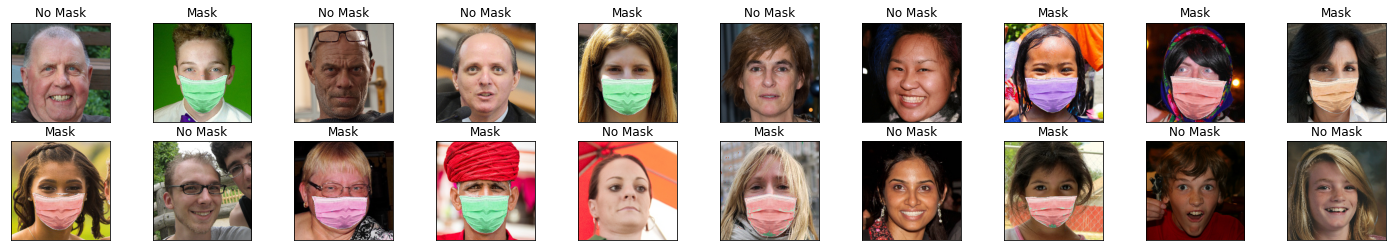

In [21]:
train_data = torch.utils.data.DataLoader(train_set, batch_size=32, num_workers=1, shuffle=True)
display_data(train_data)

#### Check Our Validation Data

<ipython-input-4-859ed0fa2aba>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


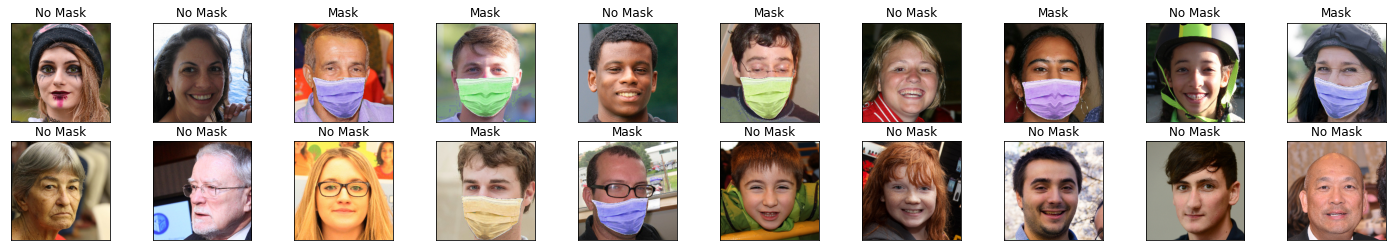

In [22]:
val_data = torch.utils.data.DataLoader(val_set, batch_size=32, num_workers=1, shuffle=True)
display_data(val_data)

#### Check Our Test Data

<ipython-input-4-859ed0fa2aba>:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])


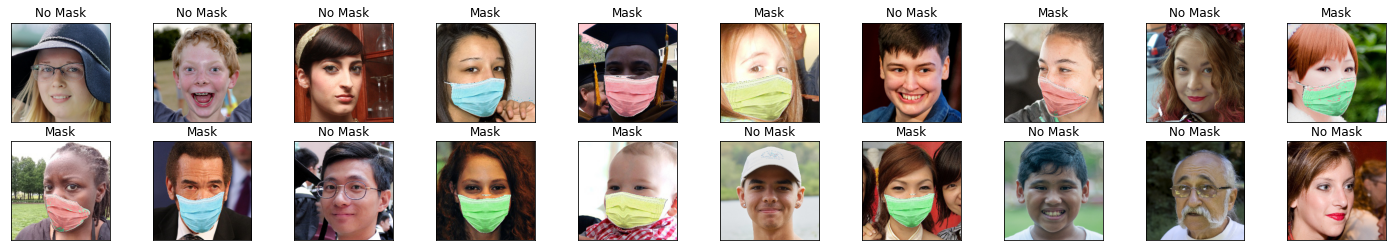

In [23]:
test_data = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=1, shuffle=True)
display_data(test_data)

## Primary Model
For our primary model, we use a basic convolutional neural network. Our input data is 224 by 224 pixel images. 

## Basic CNN Model - Version 1
This is the basic CNN version model, that has similar parameters to the CNN known as LeNet-5 (with 2 convolutional and pooling layers, followed by a flattening convolutional layer, then two linear layers). The SGD optimizer was used for our primary model because it is commonly used in CNNs and updates parameters based on each training sample.

In [13]:
class Basic_CNN(nn.Module):
    # 7 layers: 2 conv, 2 max pool, 2 linear, 1 output
    def __init__(self):
        self.name = "Basic_CNN"
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels=3, out_chanels=5, kernel_size=5
        self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels=5, out_chanels=10, kernel_size=5
        self.fc1 = nn.Linear(10*57*57, 32)
        self.fc2 = nn.Linear(32, 9)
    def weights_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight.data)
            nn.init.xavier_uniform(m.bias.data)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img))) #relu activation function
        x = self.pool(F.relu(self.conv2(x))) #relu activation function
        x = x.view(-1, 10*57*57)
        x = F.relu(self.fc1(x)) #relu activation function
        x = self.fc2(x)
        return x

In [9]:
def get_accuracy(model, data_loader):
    '''
    Gets Correct/total
    
    Model: The CNN Model
    
    data_loader: torch dataloader
    '''
    
    correct = 0
    total = 0
    for imgs, labels in data_loader:


        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################


        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [18]:
def train(model, train_dataset, val_dataset, batch_size=64, learning_rate=0.001, num_epochs=1):
    #Load data
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print("Done loading data")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    print ("Starting to train...")
    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):


            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################


            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(epoch)
        
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        print("Epoch #: {0} Accuracy: {1}".format(epoch, train_acc[epoch]))
        
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    
    best_epoch = np.argmax(val_acc)
    model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, best_epoch)
    torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [11]:
use_cuda = True
model = Basic_CNN()
# Print Basic_CNN Layers
print(model.cuda())

Basic_CNN(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)


CUDA is available!  Training on GPU ...
Done loading data
Starting to train...
Epoch #: 0 Accuracy: 0.7858663260962111
Epoch #: 1 Accuracy: 0.8646232439335888
Epoch #: 2 Accuracy: 0.8935717326521925
Epoch #: 3 Accuracy: 0.9157088122605364
Epoch #: 4 Accuracy: 0.9259259259259259
Epoch #: 5 Accuracy: 0.9306087696892295
Epoch #: 6 Accuracy: 0.9365687526607067
Epoch #: 7 Accuracy: 0.9438058748403576
Epoch #: 8 Accuracy: 0.9531715623669647
Epoch #: 9 Accuracy: 0.9561515538527032


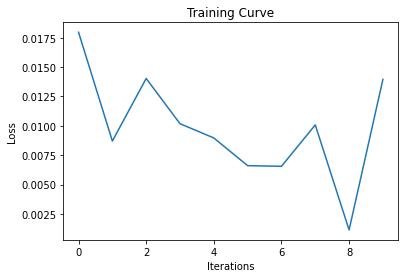

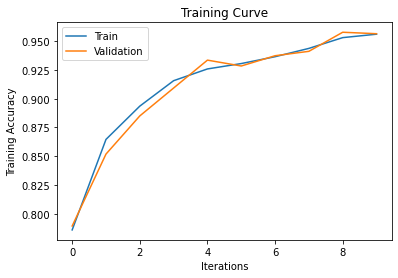

Final Training Accuracy: 0.9561515538527032
Final Validation Accuracy: 0.9565772669220945


In [24]:
use_cuda = True
torch.manual_seed(2020)
model = Basic_CNN()
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

train(model, train_set, val_set, batch_size = 32, learning_rate = 0.00012, num_epochs = 10)

In [15]:
#Test
best_model = Basic_CNN()
best_model_path = "models/model_{0}_bs{1}_lr{2}_epoch{3}".format("Basic_CNN", 32, 0.00012, 9)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("test accuracy:", test_accuracy)

test accuracy: 1.0
